# Training and Deployment:

**Multi-label audio classification fastai2 with Amazon SageMaker**

**Note - THIS IS THE GCP DEV VERSION - THE DATA FOLDER IS DIFFERENT IN SAGEMAKER, NEED TO CHANGE TO:**

```
'../data/train_curated'


The following notebook is based on the AWS demo fastai2 project (with thanks to Matt McClean for the setup instructions):

https://github.com/mattmcclean/fastai2-sagemaker-deployment-demo

We now need to train and deploy the fastai2 model on Amazon SageMaker. This notebook runs within a fastai2 kernel and environment created by a CloudFormation stack (details in the link below).

Using the steps outlined in the above demo repo the notebook will:

1. train a model locally with a SageMaker notebook instance
2. export our model and upload the model artefacts to S3 
3. deploy the model locally to the same notebook instance to test and 
4. deploy the endpoint to Amazon SageMaker to be deployed in a production setting.

**fastai2_audio**

The additional requirements of the fastai2_audio package will be dealt with below, using a clone of the following repo:

https://github.com/rbracco/fastai2_audio

The demo was run and tested by deploying an SageMaker Notebook instance as per the instructions outlined [here] (https://forums.fast.ai/t/platform-amazon-sagemaker-aws/66020).

Note - the above link is only accessible as part of the ongoing fastai course for the time being.

## GCP ONLY - INSTALL FASTAI2

In [ ]:
#Run once per session
#In Colab we need to run this as a notebook command )i.e. no '!' infront of 'pip'
#This is in comparison to shell commands i.e. with '!' infront of 'pip'
!pip install fastai2

**Download Dataset**

https://www.kaggle.com/general/74235

In [ ]:
# Install kaggle
!pip install -q kaggle

Now upload kaggle.json  API file before running next cell:

In [ ]:
# Make a directory for the json and choose the JSON file
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
 # copy JSON file
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset

! kaggle competitions download -c 'freesound-audio-tagging-2019' -p '../data/'

In [ ]:
!unzip -d ../data/ ../data/freesound-audio-tagging-2019.zip  # Unzip main data folder

In [ ]:
!unzip -d ../data/train_curated ../data/train_curated.zip; # Unzip train curated folder

In [ ]:
!unzip -d ../data/train_noisy ../data/train_noisy.zip; # Unzip train noisy folder

In [ ]:
!unzip -d ../data/test ../data/test.zip; # Unzip test folder

In [ ]:
import os
files = os.listdir('../data/train_curated')
len(files)

In [ ]:
files = os.listdir('../data/train_noisy')
len(files)

## Install the fastai2_audio library

We need to install the fastai2_audio library to the local kernel/environment for the analysis

Note the lack of `!pip` (that install to the root env) but rather standard `pip` (that installs to the current kernl/env)...

In [ ]:
#In Colab we need to run this as a shell command i.e. with '!' infront of 'pip'

!pip install git+https://github.com/rbracco/fastai2_audio.git

In [ ]:
# Solving an OSError problem with Librosa SoundFile dependency (libsndfile)
# SageMaker/GCP Only

!conda install -c conda-forge libsndfile --yes

# Train the fastai model locally
First we will train our fastai model on the notebook instance using the kernel named `fastai2`.

The audio package analysis follows guidance given within: https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/07_Audio.ipynb

In [1]:
from fastai2.vision.all import *
from fastai2_audio.core import *
from fastai2_audio.augment import *

**Create Dataframes from csv files**

**Note: Delete Corrupted and empty files list in Kaggle Competition Note**

*The following 5 audio files in the curated train set have a wrong label, due to a bug in the file renaming process: f76181c4.wav, 77b925c2.wav, 6a1f682a.wav, c7db12aa.wav, 7752cc8a.wav*

*The audio file 1d44b0bd.wav in the curated train set was found to be corrupted (contains no signal) due to an error in format conversion.*

In [2]:
# Create train Dataframes

def create_train_curated_df(file, remove_files=[]):
    df_curated = pd.read_csv(file)
    df_curated['fname'] = '../data/train_curated/' + df_curated['fname'] 
    df_curated.set_index('fname', inplace=True)
    df_curated.loc[remove_files]
    df_curated.drop(index=remove_files, inplace=True)
    df_curated.reset_index(inplace=True)
    return df_curated

def create_train_noisy_df(file):
    df_noisy = pd.read_csv(file)
    df_noisy['fname'] = '../data/train_noisy/' + df_noisy['fname'] 
    return df_noisy


def create_combined_train_df(file_curated, file_noisy, remove_files=[]):
    df_curated = pd.read_csv(file_curated)
    df_curated['fname'] = '../data/train_curated/' + df_curated['fname'] 
    
    df_noisy = pd.read_csv(file_noisy)
    df_noisy['fname'] = '../data/train_noisy/' + df_noisy['fname'] 
    
    df_combined = df_curated.append(df_noisy)
    df_combined.set_index('fname', inplace=True)
    df_combined.loc[remove_files]
    df_combined.drop(index=remove_files, inplace=True)
    df_combined.reset_index(inplace=True)
    return df_combined

In [3]:
# Create Curated training set df

# Remove corrupt and empty files as per Kaggle

remove_files = ['f76181c4.wav', '77b925c2.wav', '6a1f682a.wav', 'c7db12aa.wav', '7752cc8a.wav', '1d44b0bd.wav']
remove_files = ['../data/train_curated/' + i for i in remove_files]
df_curated = create_train_curated_df('../data/train_curated.csv', remove_files=remove_files)
df_curated.head()

,fname,labels
0,../data/train_curated/0006ae4e.wav,Bark
1,../data/train_curated/0019ef41.wav,Raindrop
2,../data/train_curated/001ec0ad.wav,Finger_snapping
3,../data/train_curated/0026c7cb.wav,Run
4,../data/train_curated/0026f116.wav,Finger_snapping


In [4]:
df_curated.describe()

,fname,labels
count,4964,4964
unique,4964,213
top,../data/train_curated/28fe2649.wav,Gong
freq,1,75


In [5]:
# Create train_noise Dataframe
df_noisy = create_train_noisy_df('../data/train_noisy.csv')
df_noisy.head()

,fname,labels
0,../data/train_noisy/00097e21.wav,Bathtub_(filling_or_washing)
1,../data/train_noisy/000b6cfb.wav,Motorcycle
2,../data/train_noisy/00116cd2.wav,"Marimba_and_xylophone,Glockenspiel"
3,../data/train_noisy/00127d14.wav,"Water_tap_and_faucet,Sink_(filling_or_washing)"
4,../data/train_noisy/0019adae.wav,Raindrop


In [6]:
df_noisy.describe()

,fname,labels
count,19815,19815
unique,19815,1168
top,../data/train_noisy/46e40972.wav,Waves_and_surf
freq,1,291


In [7]:
# Create Combined training set df

# Remove corrupt and empty files as per Kaggle
remove_files = ['f76181c4.wav', '77b925c2.wav', '6a1f682a.wav', 'c7db12aa.wav', '7752cc8a.wav', '1d44b0bd.wav']
remove_files = ['../data/train_curated/' + i for i in remove_files]
df_combined = create_combined_train_df(file_curated = '../data/train_curated.csv', 
                                       file_noisy = '../data/train_noisy.csv', 
                                       remove_files=remove_files)
df_combined.head()

,fname,labels
0,../data/train_curated/0006ae4e.wav,Bark
1,../data/train_curated/0019ef41.wav,Raindrop
2,../data/train_curated/001ec0ad.wav,Finger_snapping
3,../data/train_curated/0026c7cb.wav,Run
4,../data/train_curated/0026f116.wav,Finger_snapping


In [8]:
df_combined.describe()

,fname,labels
count,24779,24779
unique,24779,1271
top,../data/train_noisy/46e40972.wav,Waves_and_surf
freq,1,362


**Now define the data paths**

First we're going to try to train with the curated train set only to see the performance. Then we can mix both the curated and noise train set to see the results.

In [9]:
fnames = df_combined['fname']

In [10]:
fnames[:5]

0    ../data/train_curated/0006ae4e.wav
1    ../data/train_curated/0019ef41.wav
2    ../data/train_curated/001ec0ad.wav
3    ../data/train_curated/0026c7cb.wav
4    ../data/train_curated/0026f116.wav
Name: fname, dtype: object

In [11]:
len(fnames)

24779

## Using the DataBlock API:

* We'll want to use our same transforms we used for the Pipeline
* An appropriate getter
* An appropriate labeller

The following datablock method references the new and wonderful **"Fastbook"** by fastai:

https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb

and the above mentioned Audio notebook by Z Mueller.

> ### Constructing a data block
>
>How do we convert from a DataFrame object to a DataLoaders object? PyTorch and fastai have two main classes for representing and accessing a training set or validation set:
>
>* **Dataset**:: a collection which returns a tuple of your independent and dependent variable for a single item
>* **DataLoader**:: an iterator which provides a stream of mini batches, where each mini batch is a couple of a batch of independent variables and a batch of dependent variables
>
>On top of these, fastai provides two classes for bringing your training and validation sets together:
>
>* **Datasets**:: an object which contains a training Dataset and a validation Dataset
>* **DataLoaders**:: an object which contains a training DataLoader and a validation DataLoader
>
>Since a DataLoader builds on top of a Dataset, and adds additional functionality to it (collating multiple items into a mini batch), it’s often easiest to start by creating and testing Datasets, and then look at DataLoaders after that’s working.


The files in this case have multi-labels within the 'labels' column of the dataframe. 

So we will need to set the multi-labels appropriately in training.

First, we create a "datasets" object from our dataframe:


## Data Augmentation

We can use the `SpectrogramTransformer` class to prepare some transforms for us.

We need to open the audio file and convert to mel-spectrogramtensors.


In [12]:
def get_x(r): return r['fname']
def get_y(r): return r['labels'].split(',') # split labels on ','
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df_combined)
dsets.train[0]

('../data/train_noisy/9cf8b0e3.wav', ['Screaming'])

In [13]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

Let's take a look at our original settings:

In [14]:
cfg = AudioConfig.BasicMelSpectrogram()
aud2spec = AudioToSpec.from_cfg(cfg)
aud2spec.settings

{'mel': True,
 'to_db': True,
 'sample_rate': 16000,
 'n_fft': 400,
 'win_length': 400,
 'hop_length': 200,
 'f_min': 0.0,
 'f_max': None,
 'pad': 0,
 'n_mels': 128,
 'window_fn': <function _VariableFunctions.hann_window>,
 'wkwargs': None,
 'stype': 'power',
 'top_db': None}

In [15]:
aud2spec = DBMelSpec(sample_rate= 16000, f_max=None, f_min=20, n_mels=128, n_fft=1024, hop_length=128, top_db=90)
aud2spec.settings

{'mel': True,
 'to_db': True,
 'sample_rate': 16000,
 'n_fft': 1024,
 'win_length': 1024,
 'hop_length': 128,
 'f_min': 20,
 'f_max': None,
 'pad': 0,
 'n_mels': 128,
 'window_fn': <function _VariableFunctions.hann_window>,
 'wkwargs': None,
 'stype': 'power',
 'top_db': 90}

For our transforms, we'll use:
* `RemoveSilence`
  * Splits a signal at points of silence more than 2 * `pad_ms` (default is 20)
* `CropSignal`
  * Crops a signal by `duration` and adds padding if needed
* `aud2spec`
  * Our `SpectrogramTransformer` with parameters
* `MaskTime`
  * Wrapper for `MaskFre`, which applies `einsum` operations
* `MaskFreq`
  * [SpecAugment Time Masking](https://arxiv.org/abs/1904.08779)

Let's look a bit more at the padding `CropSignal` uses:

There are three different types:
* `AudioPadTypes.Zeros`: The default, random zeros before and after
* `AudioPadType.Repeat`: Repeat the signal until proper length (great for coustic scene classification and voice recognition, terrible for speech recognition)
* `AudioPadtype.ZerosAfter`: This is the default for many other libraries, just pad with zeros until you get the specified length.

In [16]:
item_tfms = [RemoveSilence(), CropSignal(3000, pad_mode='Repeat'), aud2spec, MaskTime(num_masks=1, size=100), MaskFreq(num_masks=1, size=10)]

Now let's build our `DataBlock`

The block type can be used here, combining the `AudioBlock` for the audio transforms and the `MultiCategoryBlock` for multi-label classification. This type of block expects to receive a list of strings for the different labels.

In [17]:
dblock = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
                    splitter=RandomSplitter(),
                    get_x=get_x,
                    get_y=get_y,
                    item_tfms = item_tfms)

# dsets = dblock.datasets(df_curated)
dsets = dblock.datasets(df_combined)
dsets.train[0]

(AudioTensor([[ 0.0031,  0.0030,  0.0030,  ..., -0.0010, -0.0010, -0.0010]]),
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]))

In [18]:
# Let's see what size the training and validation dataset items have

xt,yt = dsets.train[0] # xt = AudioTensor, yt = TensorMultiCategory
xt.shape,yt.shape,len(dsets.train) # show shapes and dataset size (no. items)

(torch.Size([1, 506268]), torch.Size([80]), 19824)

In [19]:
xv,yv = dsets.valid[0]
xv.shape,yv.shape,len(dsets.valid)

(torch.Size([1, 661500]), torch.Size([80]), 4955)

In the above we can see the created audiotensor and the one-hot encoded labels: TensorMultiCategory.

Let’s check what the categories represent for this example (we are using the convenient torch.where function, which tells us all of the indices where our condition is true or false). 

With numpy arrays, PyTorch tensors, and fastai’s L class, you can index directly using a list or vector, which makes a lot of code (such as this example) much clearer and more concise.

In [20]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['Buzz']

**Now we define our DataLoader**

A `DataLoader` collates the items from a `Dataset` into a mini batch. This is a tuple of tensors, where each tensor simply stacks the items from that location in the `Dataset` item. Now that we have confirmed that the individual items look okay there's one more step we need to ensure we can create our DataLoaders.

In [21]:
dls = dblock.dataloaders(df_combined, bs=32)
# dls = dblock.dataloaders(df_noisy, bs=64)

x,y = dls.one_batch()
x.mean(),x.std()

(AudioSpectrogram(-18.4389, device='cuda:0'),
 AudioSpectrogram(24.1157, device='cuda:0'))

In [22]:
# Let's check our batch shape
dls.one_batch()[0].shape

torch.Size([32, 1, 128, 1034])

Let's look at some augmented data:

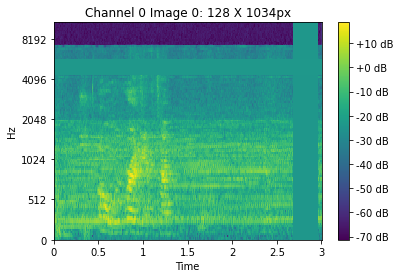

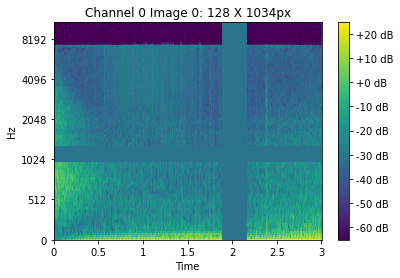

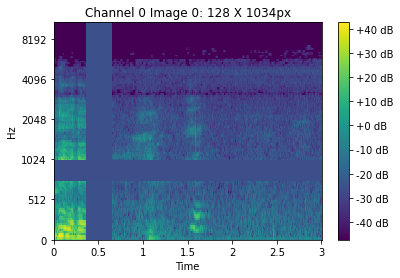

Buzz
Finger_snapping
Burping_and_eructation;Squeak


In [23]:
dls.show_batch(max_n=3)

## Training

Now that we have our `Dataloaders`, we need to make a model. We'll make a function that changes a `Learner`'s first layer to accept a 1 channel input.

Let's make an audio_learner function which is similar to a cnn_learner. In addition, the learner will need the Binary Cross Entropy Loss, so we will need to combine both the approach from the fastai multicat notebook:

https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb

and the fastai2 audio learner creation.

This will need the following steps:



1.   Create a standard CNN Learner
2.   Get the activation sizes from a single mini-batch
3. Pass the activation sizes to the BCELoss Function
4. Pass the BCE Loss function to the `audiolearner` function, which augments the Leaner to accept a single channel input




**Note on Multi-category Loss Function**

Fastbook:

>We also saw that the model in a Learner is generally an object of a class inheriting from nn.Module, and that you can call it using parentheses and it will return the activations of a model. You should pass it your independent variable, as a mini batch. We can try it out by grabbing a mini batch from our DataLoader, and then passing it to the model:

>Note that because we have a one-hot encoded dependent variable, we can't directly use nll_loss or softmax (and therefore we can't use cross_entropy).

>Normally for one-hot encoded targets you'll want F.binary_cross_entropy_with_logits (or nn.BCEWithLogitsLoss), which do both sigmoid and binary cross entropy in a single function, as in our example above.

***With a standard learner, we don't normally need to tell fastai to use this loss function since it will be automatically chosen for us using the DataLoaders recognising multiple category labels. However, as we are creating an audio_learner, we need to provide the loss function to the audio_learner() function defined above.***

>One change compared to the last chapter is the metric we use: since we are in a multilabel problem, we can't use the accuracy function

>The class predicted was the one with the highest activation (this is what argmax does). Here it doesn't work because we could have more than one prediction on a single image. After applying the sigmoid to our activations (to make them between 0 and 1), we need to decide which ones are 0s and which ones are 1s by picking a threshold. Each value above the threshold will be considered as a 1, and each value lower than the threshold will be considered a 0. 

>If we pass accuracy_multi directly as a metric, it will use the default value for threshold, which is 0.5. We might want to adjust that default and create a new version of accuracy_multi that has a different default. 

>Picking a threshold is important. If you pick a threshold that's too low, you'll often be failing to select correctly labelled objects. If you pick a threshold that's too high, you'll often be selecting correctly labelled objects. We can see this by changing our metric, and then calling validate, which returns the validation loss and metrics. 

In this case, we're going to use BCEWithLogitsLossFlat():

```"Same as `nn.CrossEntropyLoss`, but flattens input and target."```

say the fastai docs - double check.

Also, we change the output to be 80 neurons to match the label amount.


## Using an LWL-wrap Metric

For the Kaggle competition the metric used was lwl wrap:

_The primary competition metric will be label-weighted label-ranking average precision (lwlrap, pronounced "Lol wrap"). This measures the average precision of retrieving a ranked list of relevant labels for each test clip (i.e., the system ranks all the available labels, then the precisions of the ranked lists down to each true label are averaged). This is a generalization of the mean reciprocal rank measure (used in last year’s edition of the competition) for the case where there can be multiple true labels per test item. The novel "label-weighted" part means that the overall score is the average over all the labels in the test set, where each label receives equal weight (by contrast, plain lrap gives each test item equal weight, thereby discounting the contribution of individual labels when they appear on the same item as multiple other labels)._

_We use label weighting because it allows per-class values to be calculated, and still have the overall metric be expressed as simple average of the per-class metrics (weighted by each label's prior in the test set). For participant’s convenience, a Python implementation of lwlrap is provided in [this](https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8) public Google Colab._

An implementation for fastai is also outlined within this competition kernel, used below:

https://www.kaggle.com/daisukelab/cnn-2d-basic-solution-powered-by-fast-ai


**Note: we will also need to experiment with the spectrogram augmentation**

In [24]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class


# Wrapper for fast.ai library
def lwlrap(scores, truth, **kwargs):
    score, weight = calculate_per_class_lwlrap(to_np(truth), to_np(scores))
    return torch.Tensor([(score * weight).sum()])

# Staged Training Approach

1. Stage 1 - train on curated_train only + fine tune. Freeze again before next stage.
2. Stage 2 - train and validation on noisy_train + fine-tune.
3. Stage 3 - Inference on Test test set. Submit to kaggle to see results.

## Stage 1 - Train on Noisy Set

 - Original transforms below (for xresnet50)

In [25]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

In [26]:
clip_length = 2
sr = 44100
f_min = 20
f_max = 18000
n_mels = 128
hop_length = math.ceil((clip_length*sr)/n_mels)# determines width of image. for square to match n_mels, set math.ceil((clip_length*sr)/n_mels)
nfft = n_mels * 16 # options: 2^n, n_mels*20
win_length = 1024
top_db = 80

In [27]:
cfg = AudioConfig.BasicMelSpectrogram()
aud2spec = AudioToSpec.from_cfg(cfg)
aud2spec = DBMelSpec(sample_rate=sr, win_length=win_length, f_max=f_max, f_min=f_min, n_mels=n_mels, n_fft=nfft, hop_length=hop_length, top_db=top_db)
aud2spec.settings

{'mel': True,
 'to_db': True,
 'sample_rate': 44100,
 'n_fft': 2048,
 'win_length': 1024,
 'hop_length': 690,
 'f_min': 20,
 'f_max': 18000,
 'pad': 0,
 'n_mels': 128,
 'window_fn': <function _VariableFunctions.hann_window>,
 'wkwargs': None,
 'stype': 'power',
 'top_db': 80}

In [28]:
item_tfms = [RemoveSilence(threshold=15), 
             CropSignal(clip_length*1000, 
                        pad_mode='Repeat'), 
             aud2spec, 
             MaskTime(num_masks=1, size=6), MaskFreq(num_masks=1, size=6)]

Now define batch transforms

In [30]:
batch_tfms = [Normalize(),
              RatioResize(256),
              Brightness(max_lighting=0.2, p=0.75),
              Contrast(max_lighting=0.2, p=0.75)]

## 90% Noisy Train


From: https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/63f3a652d7d0267d3f417c8d76817d9ddcdea2dd/Computer%20Vision/03_Cross_Validation.ipynb

and 

https://github.com/ebouteillon/freesound-audio-tagging-2019/blob/master/code/training-cnn-model1.ipynb

**Bag of Tricks xresnet50 also incorporating:**

* Mish activation fucntion
* Self Attention
* MaxblurPool
* Ranger optimization function

In [40]:
pip install kornia

Note: you may need to restart the kernel to use updated packages.


In [31]:
# Adopted from 
# https://discuss.pytorch.org/t/how-can-i-replace-an-intermediate-layer-in-a-pre-trained-network/3586/7
import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model

Ranger + Fit-Flat-Cosine

In [32]:
opt_func = ranger

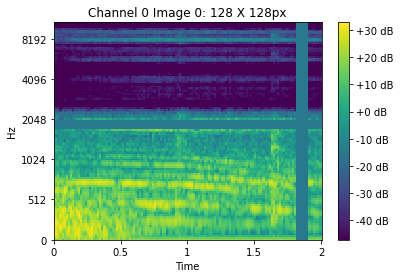

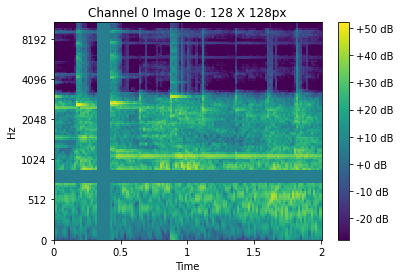

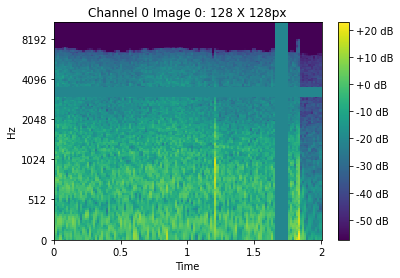

Male_speech_and_man_speaking
Chink_and_clink
Waves_and_surf


epoch,train_loss,valid_loss,lwlrap,time
0,0.067207,0.066899,0.258804,03:33
1,0.060314,0.063619,0.312953,03:50
2,0.057555,0.060091,0.375209,03:51
3,0.055152,0.056529,0.424795,03:49
4,0.053291,0.054072,0.463046,03:51
5,0.051928,0.052792,0.479345,03:50
6,0.050510,0.055728,0.438898,03:51
7,0.049020,0.052789,0.481930,03:50
8,0.048977,0.052512,0.479354,03:50
9,0.047321,0.051892,0.495719,03:49


Saving Learner...


In [36]:
df = df_noisy # to use random subset, use  df = df_.sample(frac=0.5, replace=False, random_state=1) # take random subset of the noisy dataframe for faster training (otherwise need 6.5 hours for all folds with complete dataset)

def get_x(r): return r['fname']
def get_y(r): return r['labels'].split(',') # split labels on ','

dblock = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
                  splitter=RandomSplitter(valid_pct=0.1, random_seed=42), # split using df index
                  get_x=get_x,
                  get_y=get_y,
                  item_tfms = item_tfms,
                  batch_tfms = batch_tfms
                )

dls = dblock.dataloaders(df, bs=64)
dls.show_batch(max_n=3)

model = xresnet50(pretrained=False, act_cls=Mish, sa=True, c_in=1, n_out=80) #create custom xresnet: 1 input channel,  80 output nodes, self-attention, Mish activation function
model = convert_MP_to_blurMP(model, nn.MaxPool2d) # convert MaxPool2D layers to MaxBlurPool
learn = Learner(dls, model=model, loss_func=BCEWithLogitsLossFlat(), metrics=[lwlrap]) # pass custom model to Learner, no mixup for noisy set as fewer epochs

learn.fit_flat_cos(20, lr=3e-3)
# print('Fine-tuning')
# # learn.unfreeze()
# learn.fit_flat_cos(10, lr=3e-3/3)

print('Saving Learner...')
learn.save(f'stage-1_noisy_sota_norm')

## Stage 2 - Train on Curated Train set

**Best so far 66% - pretrained xresnet50 - Noisy set: 10 epochs, 10 epochs finetune. Curated: 5-Folds validation for 100 epochs unfrozen. **

* Model = 'xresnet50-stage-2-curated-128-re256-finetune-mixup'

* batch_tfms = [Normalize.from_stats(*imagenet_stats),
             RatioResize(256),
             Brightness(max_lighting=0.2),
             Contrast(max_lighting=0.2)]])            
* 100 epochs unfrozen
* with mixup
* with tta


clip_length = 2
sr = 44100
f_min = 20
f_max = 18000
n_mels = 128
hop_length = math.ceil((clip_length*sr)/n_mels)# determines width of image. for square to match n_mels, set math.ceil((clip_length*sr)/n_mels)
nfft = n_mels * 16 # options: 2^n, n_mels*20
win_length = 1024
top_db = 80

item_tfms = [RemoveSilence(threshold=15), 
             CropSignal(clip_length*1000, 
                        pad_mode='Repeat'), 
             aud2spec, 


## K-Folds Cross-Validation on Curated Train Set

In [33]:
from sklearn.model_selection import KFold

In [34]:
# Declare Number Folds 
n_splits = 5

kf = KFold(n_splits=n_splits, random_state=42, shuffle=True) # random_state for repeatable results, shuffle indices

In [35]:
# Scale up images to 256x256px for progressive resizing on Curated Set

batch_tfms = [Normalize(),
              RatioResize(256),
              Brightness(max_lighting=0.2, p=0.75),
              Contrast(max_lighting=0.2, p=0.75)]


Curated Train Set - Fold 1/5


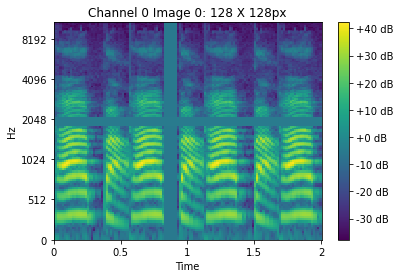

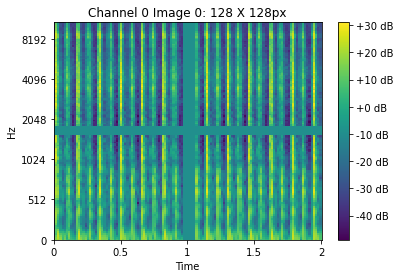

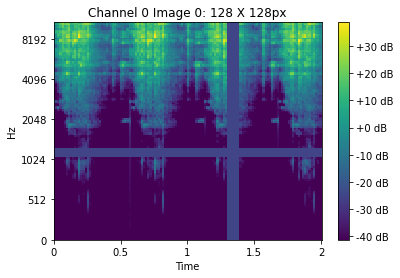

Child_speech_and_kid_speaking
Computer_keyboard
Keys_jangling
Loading Stage 1 model.
Training on Curated Set:


epoch,train_loss,valid_loss,lwlrap,time
0,0.058752,0.041047,0.623465,00:24
1,0.050608,0.035822,0.697132,00:21
2,0.045738,0.033227,0.712433,00:21
3,0.043392,0.031968,0.729007,00:21
4,0.041420,0.030235,0.755270,00:21
5,0.039843,0.029280,0.760844,00:21
6,0.038653,0.029238,0.763943,00:21
7,0.037789,0.028082,0.777492,00:21
8,0.036277,0.027592,0.772377,00:21
9,0.035690,0.028060,0.770688,00:21


Saving model...

Curated Train Set - Fold 2/5


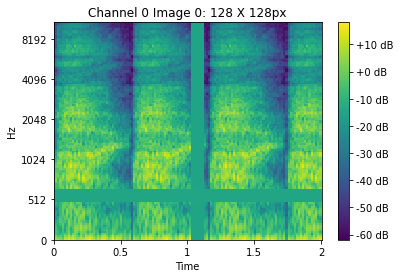

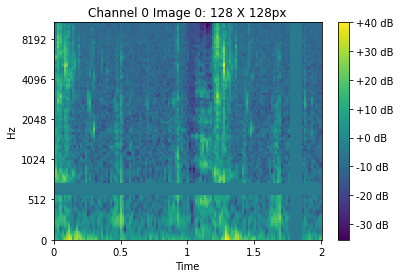

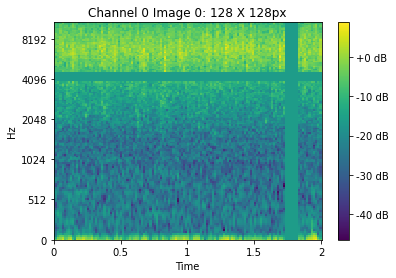

Whispering
Burping_and_eructation;Chewing_and_mastication
Bathtub_(filling_or_washing)
Loading Stage 1 model.
Training on Curated Set:


epoch,train_loss,valid_loss,lwlrap,time
0,0.059176,0.040873,0.626732,00:22
1,0.050958,0.035720,0.689206,00:22
2,0.046101,0.033377,0.714116,00:22
3,0.043583,0.031939,0.731415,00:21
4,0.041645,0.030171,0.752133,00:21
5,0.040136,0.029597,0.754332,00:22
6,0.038910,0.028597,0.766655,00:22
7,0.037600,0.028560,0.767132,00:22
8,0.036081,0.027759,0.773067,00:22
9,0.035513,0.027339,0.772874,00:22


Saving model...

Curated Train Set - Fold 3/5


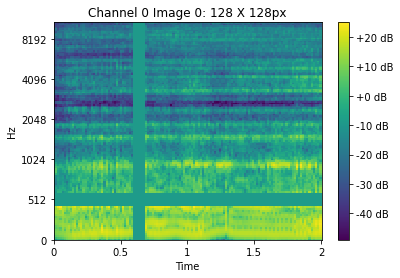

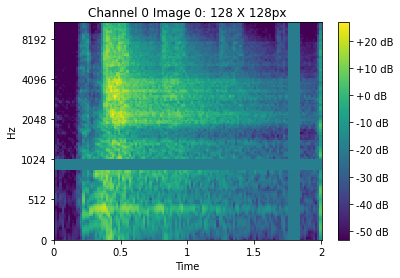

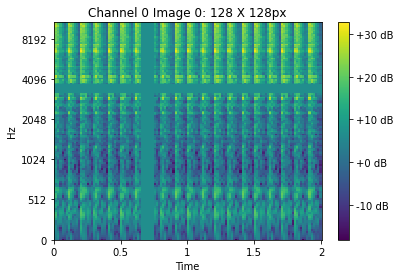

Burping_and_eructation
Sneeze
Hi-hat
Loading Stage 1 model.
Training on Curated Set:


epoch,train_loss,valid_loss,lwlrap,time
0,0.059040,0.040221,0.625591,00:22
1,0.050717,0.034770,0.698211,00:22
2,0.046372,0.032539,0.719874,00:22
3,0.044104,0.031149,0.736312,00:22
4,0.042009,0.030043,0.752753,00:22
5,0.040642,0.029079,0.755799,00:22
6,0.039002,0.028541,0.758845,00:22
7,0.037490,0.028166,0.765704,00:22
8,0.036611,0.027245,0.775582,00:22
9,0.036077,0.026965,0.762214,00:21


Saving model...

Curated Train Set - Fold 4/5


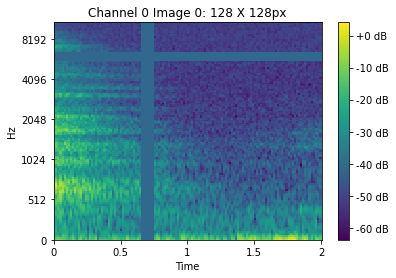

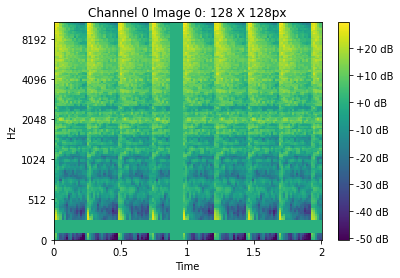

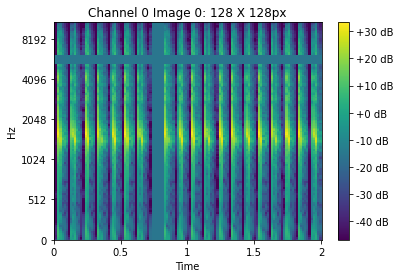

Sigh
Hi-hat
Finger_snapping
Loading Stage 1 model.
Training on Curated Set:


epoch,train_loss,valid_loss,lwlrap,time
0,0.059002,0.040279,0.625535,00:22
1,0.050508,0.034877,0.688893,00:22
2,0.046380,0.031563,0.734943,00:22
3,0.043630,0.031343,0.727986,00:22
4,0.041720,0.030155,0.748370,00:22
5,0.040215,0.028671,0.759138,00:22
6,0.038640,0.028504,0.758599,00:22
7,0.037763,0.027395,0.776214,00:22
8,0.036636,0.027419,0.771304,00:22
9,0.035474,0.027528,0.771567,00:22


Saving model...

Curated Train Set - Fold 5/5


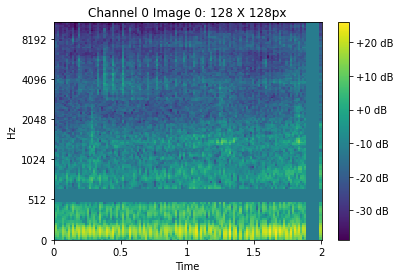

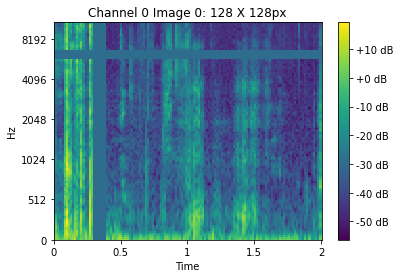

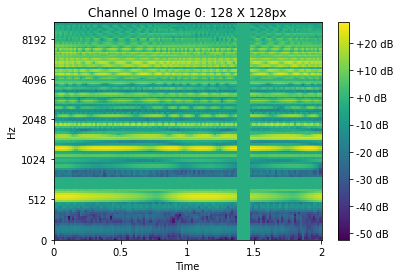

Motorcycle
Chewing_and_mastication
Harmonica
Loading Stage 1 model.
Training on Curated Set:


epoch,train_loss,valid_loss,lwlrap,time
0,0.059123,0.040350,0.623952,00:23
1,0.050872,0.035055,0.689601,00:22
2,0.046183,0.032549,0.719820,00:22
3,0.043578,0.031288,0.735723,00:22
4,0.041405,0.029960,0.747250,00:22
5,0.040210,0.029499,0.743942,00:22
6,0.039142,0.028848,0.756318,00:22
7,0.037667,0.027628,0.769216,00:22
8,0.036818,0.027419,0.770289,00:22
9,0.035849,0.026602,0.781283,00:22


Saving model...


In [36]:
## K-Folds training loop

# Use Sci-Kit learn splitter to provide index splits

df = df_curated

for fold, (train_idx, valid_idx) in enumerate(kf.split(df)):
    print(f'\nCurated Train Set - Fold {fold+1}/{n_splits}')

    def get_x(r): return r['fname']
    def get_y(r): return r['labels'].split(',') # split labels on ','

    dblock = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
                        splitter=IndexSplitter(valid_idx), # split using df index
                        get_x=get_x,
                        get_y=get_y,
                        item_tfms = item_tfms,
                       batch_tfms = batch_tfms # including RatioResize(256)
                      )

    dls = dblock.dataloaders(df, bs=64)

    dls.show_batch(max_n=3)

    print(f'Loading Stage 1 model.')
    
    model = xresnet50(pretrained=False, act_cls=Mish, sa=True, c_in=1, n_out=80) #create custom xresnet: 1 input channel,  80 output nodes, self-attention, Mish activation function
    model = convert_MP_to_blurMP(model, nn.MaxPool2d) # convert MaxPool2D layers to MaxBlurPool
    learn = Learner(dls, model=model, loss_func=BCEWithLogitsLossFlat(), metrics=[lwlrap]) # pass custom model to Learner, no mixup for noisy set as fewer epochs
    
    learn.load('stage-1_noisy_sota_norm')
    learn.add_cb(MixUp(0.5)) # add mixup callback
    
    learn.dls = dls
    learn.summary()
    
    print('Training on Curated Set:')
    learn.fit_flat_cos(50, 3e-3/4)

    print('Saving model...')
    learn.save(f'stage-2_curated_fold-{fold}_sota')
    
    

## Test model on Test set and upload to Kaggle to see results

In [ ]:
# Load saved learner for testing

learn = learn.load('xresnet50-stage-2-curated-128-re256-finetune-mixup')

In [ ]:
# Get predictions using Learner test data loader without TTA

df_fnames = pd.read_csv('../data/sample_submission.csv')
fnames = df_fnames.fname
df_fnames = '../data/test/' + df_fnames.fname
print(df_fnames[:5])

dl = learn.dls.test_dl(df_fnames)
preds,_,dec_preds = learn.get_preds(dl=dl, with_decoded=True)
# full_dec = learn.dls.decode_batch((*tuplify(inp),*tuplify(dec_preds)))
# full_dec

In [ ]:
# Now try test-time augmentations

preds, targs = learn.tta(dl=dl)

In [ ]:
df_sub = pd.DataFrame(preds)
df_sub.columns = learn.dls.vocab
df_sub.insert(0, "fname", 0)
df_sub.fname = fnames
df_sub.head()

In [ ]:
df_sub.to_csv('submission-xresnet50-stage-2-curated-128-re256-mixup-2560nnft-with-tta.csv', index=False)

## Test Using All Folds and Models

In [37]:
predictions = None

# grab test files from submission csv
df_fnames = pd.read_csv('../data/sample_submission.csv')
fnames = df_fnames.fname
df_fnames = '../data/test/' + df_fnames.fname
print(df_fnames[:5])

# get predictions
for fold in range(n_splits):
    stage = 2
    print(f'getting predictions from stage {stage} fold {fold} model.')
    learn = learn.load(f'stage-2_curated_fold-{fold}_sota')

    dl = learn.dls.test_dl(df_fnames)
    
    # predict using tta    
    preds, targs = learn.tta(dl=dl)
    preds = preds.cpu().numpy()
    
    if fold == 0:
        predictions = preds
    else:
        predictions += preds


# Average predictions
predictions /= n_splits

# Create Submission DataFrame    
df_sub = pd.DataFrame(predictions)
df_sub.columns = learn.dls.vocab
df_sub.insert(0, "fname", 0)
df_sub.fname = fnames
df_sub.head()

0    ../data/test/4260ebea.wav
1    ../data/test/426eb1e0.wav
2    ../data/test/428d70bb.wav
3    ../data/test/4292b1c9.wav
4    ../data/test/429c5071.wav
Name: fname, dtype: object
getting predictions from stage 2 fold 0 model.


getting predictions from stage 2 fold 1 model.


getting predictions from stage 2 fold 2 model.


getting predictions from stage 2 fold 3 model.


getting predictions from stage 2 fold 4 model.


,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,4260ebea.wav,0.000111,0.000112,0.000129,0.000119,0.000333,0.000032,0.000214,0.010802,0.001277,...,0.000737,0.000170,0.002129,0.000236,0.046355,0.000046,0.000076,0.000984,0.002774,0.002270
1,426eb1e0.wav,0.000043,0.000013,0.000131,0.932177,0.000451,0.000043,0.000114,0.001377,0.000285,...,0.000633,0.000776,0.000345,0.002166,0.000081,0.000519,0.000310,0.000433,0.000020,0.000084
2,428d70bb.wav,0.000137,0.001738,0.000060,0.000057,0.000180,0.000047,0.000036,0.000351,0.000110,...,0.000116,0.002421,0.000891,0.004080,0.000067,0.001663,0.015698,0.000264,0.000409,0.000539
3,4292b1c9.wav,0.000426,0.000035,0.000184,0.001351,0.000283,0.000074,0.000090,0.000054,0.000137,...,0.000784,0.000066,0.000835,0.000071,0.000075,0.000005,0.000044,0.000013,0.010350,0.000088
4,429c5071.wav,0.002604,0.000070,0.000601,0.000444,0.002593,0.003265,0.001741,0.001053,0.000621,...,0.002497,0.004223,0.000474,0.021491,0.003671,0.010713,0.006372,0.005767,0.000535,0.024312


In [38]:
df_sub.to_csv('submission-stage-2-5kfold.csv', index=False)

In [ ]:
learn.show_results()

## Comparison of model performance and analysis

**Model descriptions**

66% method:

Use stage-1-noisy-


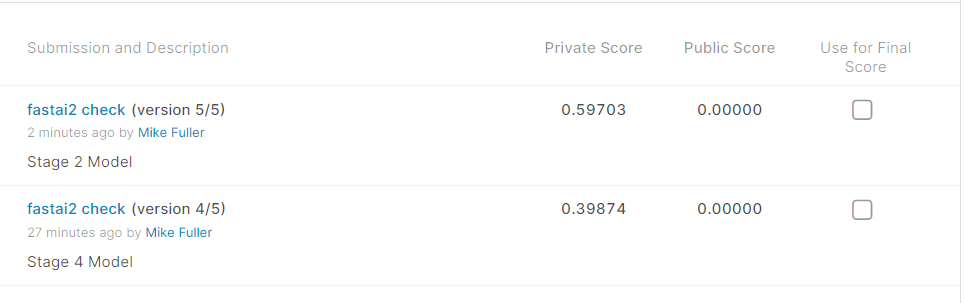


Clearly, the effect of training with such noisy labels in the noisy train set is deleterious to the test set performance. As such, we will need to consider how the noisy training set is used extremely carefully. E.g. within https://medium.com/@mp.music93/multi-label-audio-classification-7th-place-public-lb-solution-for-freesound-audio-tagging-2019-a7ccc0e0a02f they used only the correctly predicted items from the test set within training.



In real-terms, however, the model is very good at making single or multi-label predictions on new data. Perhaps not in the lwlwrap metric terms, but in a multi-label case it is actually quite accurate.


## References 

https://www.kaggle.com/c/freesound-audio-tagging-2019

https://github.com/rbracco/fastai2_audio

https://github.com/fastai/fastai2

https://github.com/fastai/fastbook

https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0

https://github.com/ebouteillon/freesound-audio-tagging-2019#Data-Augmentation

https://medium.com/@mnpinto/multi-label-audio-classification-7th-place-public-lb-solution-for-freesound-audio-tagging-2019-a7ccc0e0a02f

